In [35]:
import torch
import torch.nn as nn
import bitsandbytes as bnb
import matplotlib.pyplot as plt

from collections import defaultdict

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        
    def forward(self, x):
        return self.linear(x)

In [108]:
lr = 1e-3

optimizers = [
    (bnb.optim.Lion8bit, lr/5),
    (bnb.optim.AdamW, lr),
]

per_opt_loss = defaultdict(list)

test_func = lambda x: 2*x - 3
criterion = torch.nn.MSELoss()
batch_size = 4
n_epochs = 512

for optimizer_class, lr in optimizers:
    print(optimizer_class.__name__)
    
    net = Net().cuda()
    optimizer = optimizer_class(net.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        # x is unform in [-50, 50]
        x = 50 * 2 * (torch.rand((batch_size, 1), device="cuda") - 0.5)

        target = test_func(x)
        pred = net(x)

        loss = criterion(target, pred)
        loss.backward()
        per_opt_loss[optimizer_class.__name__].append(loss.item())
        
        optimizer.step()
        optimizer.zero_grad()
        
    print("end loss:", loss.item())

Lion8bit
end loss: 5.071094512939453
AdamW
end loss: 1.2355672121047974


start_idx: 0


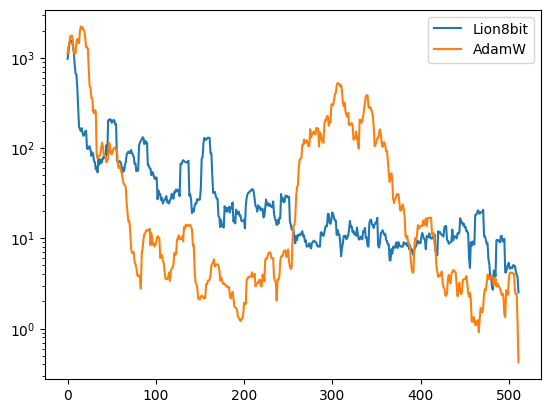

In [109]:
import numpy as np

def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

fig, ax = plt.subplots()

max_loss = 10000.0

for start_idx in range(n_epochs):
    if all(ls[start_idx] < max_loss for ls in per_opt_loss.values()):
        print("start_idx:", start_idx)
        break
else:
    raise Exception(f"No valid loss below limit ({max_loss})")

for opt, losses in per_opt_loss.items():
    ax.plot(smooth(losses[start_idx:], 10), label=opt)
    
ax.set_yscale("log")
ax.legend()